In [ ]:
import os

current_directory = os.getcwd()
print("Current working directory:", current_directory)

In [3]:
import os

# Set the Training dataset path
INPUT_DATASET_PATH = "../input/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"

# Count the number of subfolders within the folder
def count_subfolders(folder_path):
    """
    Count the number of immediate subfolders inside the given folder path.
    
    Args:
    - folder_path (str): The path to the folder for which the subfolder count is required.
    
    Returns:
    - int: The number of immediate subfolders present inside the given folder path.
    """
    num_subfolders = sum(1 for _ in os.scandir(folder_path) if _.is_dir())
    return num_subfolders


def check_files_in_subfolders(folder_path, file_count=5):
    """
    Checks if all subfolders in the given folder path have the expected number 
    of files and modalities.

    Args:
        folder_path (str): Path to folder containing subfolders to check.
        file_count (int): Expected number of files in each subfolder.

    Returns:
        str: "All records/subfolders have all modalities" if each subfolder  
            contains exactly file_count files of the expected modalities.
            "Not all records/subfolders have all modalities" otherwise.
    """
    all_records_have_all_modalities = True
    
    for root, dirs, files in os.walk(folder_path):
        for subdir in dirs:
            subfolder_path = os.path.join(root, subdir)
            subfolder_files = os.listdir(subfolder_path)
            
            if len(subfolder_files) != file_count:
                print("Subfolder", subdir, f"does not have exactly {file_count} files.")
                all_records_have_all_modalities = False
                continue
                
            expected_files = [subdir + ext for ext in ['-t1n.nii.gz', '-t1c.nii.gz', '-t2w.nii.gz', '-t2f.nii.gz', '-seg.nii.gz']][:file_count]
            
            if not all(file in subfolder_files for file in expected_files):
                print("Subfolder", subdir, "does not have the expected files.")
                all_records_have_all_modalities = False
                continue

    if all_records_have_all_modalities:
        return "All records/subfolders have all modalities"
    else:
        return "Not all records/subfolders have all modalities"
        

# Count the number of files in the input folder
input_num_files = count_subfolders(INPUT_DATASET_PATH)
print("Number of records in the input folder:", input_num_files)


# Check subfolders in the training folder
modality_check = check_files_in_subfolders(INPUT_DATASET_PATH)
print(modality_check)


Number of records in the input folder: 1251
All records/subfolders have all modalities


No missing modalities found within the training or validation set

In [4]:
#!pip install nibabel

import numpy as np
import nibabel as nib  
# nibabel is a Python library that provides read and write access to various medical imaging file formats

image_path = INPUT_DATASET_PATH + "/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t2f.nii.gz"

# loads the NIfTI image
test_image_obj = nib.load(image_path)
print("Type of Image object is ",type(test_image_obj))

#  extracts the image data from the image_obj object using the get_fdata() method
#  It returns a 3D or 4D NumPy array containing the voxel values of the image
test_image_data = test_image_obj.get_fdata()
print("Type of data in Image object is ",type(test_image_data))
print("Shape of data in Image object is ",test_image_data.shape)

Type of Image object is  <class 'nibabel.nifti1.Nifti1Image'>
Type of data in Image object is  <class 'numpy.ndarray'>
Shape of data in Image object is  (240, 240, 155)


In [5]:
# Loading mask image
test_mask = nib.load(INPUT_DATASET_PATH + "/BraTS-GLI-00002-000/BraTS-GLI-00002-000-seg.nii.gz").get_fdata()
test_mask = test_mask.astype(np.uint8)

# Checking Mask shape and type
print("Type of data in Image object is ",type(test_mask))
print("Shape of data in Image object is ",test_mask.shape)

# Getting all unique segmentation labels
print("Unique Segmentation labels are ",np.unique(test_mask))


Type of data in Image object is  <class 'numpy.ndarray'>
Shape of data in Image object is  (240, 240, 155)
Unique Segmentation labels are  [0 1 2 3]


In [ ]:
import matplotlib.pyplot as plt

def analyze_segmentation_labels(folder_path):   
    """
    Analyzes the segmentation labels within the -seg.nii.gz files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the segmentation files.

    Returns:
        dict: A dictionary representing the label distribution, where the keys are the unique labels
              and the values are the corresponding counts.

    """
    label_counts = {}

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith("-seg.nii.gz"):
                file_path = os.path.join(root, file)
                seg_image = nib.load(file_path)
                seg_data = seg_image.get_fdata()
                unique_labels, label_counts_per_file = np.unique(seg_data, return_counts=True)
                
                for label, count in zip(unique_labels, label_counts_per_file):
                    if label not in label_counts:
                        label_counts[label] = count
                    else:
                        label_counts[label] += count
    
    return label_counts

# Analyze segmentation labels in the training folder
label_counts = analyze_segmentation_labels(INPUT_DATASET_PATH)

# Calculate the total count of labels
total_count = sum(label_counts.values())

# Calculate the percentage values
percentages = [count/total_count * 100 for count in label_counts.values()]

# Plot the label distribution with percentages on the x-axis
labels = list(int(x) for x in label_counts.keys())

plt.bar(labels, percentages)
plt.xlabel("Segmentation Label")
plt.ylabel("Percentage")
plt.title("Distribution of Segmentation Labels")

# Annotate each bar with its percentage value
for i, v in enumerate(percentages):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

plt.xticks(range(len(labels)), labels)  # Set x-ticks to integer labels

plt.box(False)  # Remove bounding box

plt.show()

In [7]:
#!pip install tabulate
from tabulate import tabulate

# Create a list of lists containing the data
table_data = []
for label, count, percentage in zip(label_counts.keys(), label_counts.values(), percentages):
    table_data.append([label, str(count), f"{percentage:.2f}%"])

# Specify the table headers
headers = ["Label", "Count", "Percentage"]

# Print the table
print(tabulate(table_data, headers, tablefmt="grid"))


+---------+-------------+--------------+
|   Label |       Count | Percentage   |
+=========+=============+==============+
|       0 | 11048872504 | 98.93%       |
+---------+-------------+--------------+
|       1 |    17896396 | 0.16%        |
+---------+-------------+--------------+
|       2 |    75328509 | 0.67%        |
+---------+-------------+--------------+
|       3 |    26830591 | 0.24%        |
+---------+-------------+--------------+


In [6]:
import matplotlib.pyplot as plt

def analyze_segmentation_labels(folder_path):   
    """
    Analyzes the segmentation labels within the -seg.nii.gz files in the specified folder.

    Args:
        folder_path (str): Path to the folder containing the segmentation files.

    Returns:
        dict: A dictionary representing the label distribution, where the keys are the unique labels
              and the values are the corresponding counts.

    """
    label_counts = {}

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith("-seg.nii.gz"):
                file_path = os.path.join(root, file)
                seg_image = nib.load(file_path)
                seg_data = seg_image.get_fdata()
                unique_labels, label_counts_per_file = np.unique(seg_data, return_counts=True)
                
                for label, count in zip(unique_labels, label_counts_per_file):
                    if label not in label_counts:
                        label_counts[label] = count
                    else:
                        label_counts[label] += count
    
    return label_counts
    
# Analyze segmentation labels in the training folder
label_counts = analyze_segmentation_labels(INPUT_DATASET_PATH)

# Calculate the total count of labels
total_count = sum(label_counts.values())

# Calculate the percentage values
percentages = [count/total_count * 100 for count in label_counts.values()]

# Labels for the plots
labels = list(str(x) for x in label_counts.keys())  # Converted to string for better labeling in pie chart




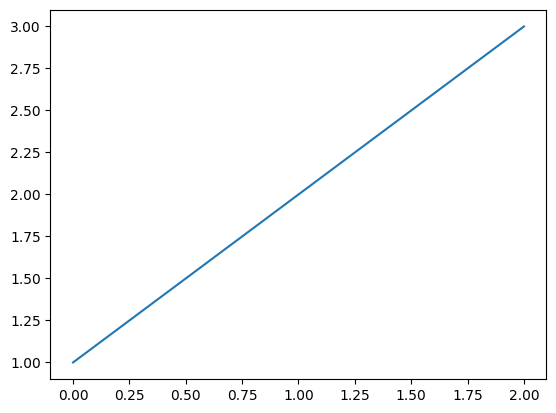

In [7]:
plt.plot([1,2,3])
plt.show()

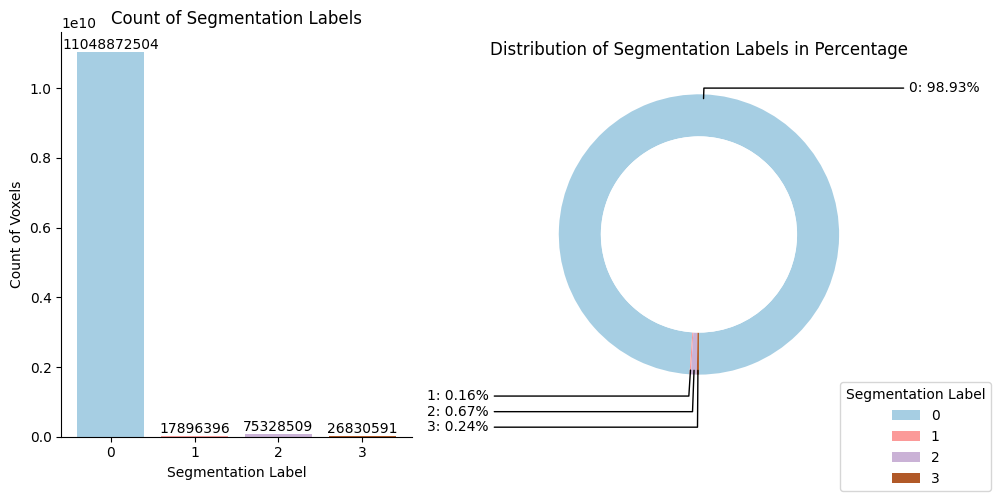

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Colors for both pie and bar plots (using the paired colormap)
colors = plt.cm.Paired(np.linspace(0, 1, len(labels)))

# Bar Plot for Actual Counts
bars = ax[0].bar([int(float(label)) for label in labels], label_counts.values(), color=colors)
ax[0].set_xlabel("Segmentation Label")
ax[0].set_ylabel("Count of Voxels")
ax[0].set_title("Count of Segmentation Labels")
for i, v in enumerate(label_counts.values()):
    ax[0].text(i, v + 1, str(v), ha='center', va='bottom')

# Remove top and right spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# Pie Chart with Percentage
# Pie chart 
wedges, texts, autotexts = ax[1].pie(percentages,  
                                     colors=colors,
                                     labels=None,
                                     autopct='',
                                     startangle=-90, 
                                     pctdistance=0.85,
                                     wedgeprops=dict(width=0.3))

# Set the title and adjust its position and vertical alignment
title2 = ax[1].set_title("Distribution of Segmentation Labels in Percentage", va='center')
title2.set_y(-1.05)  # Adjust the vertical position of the title

# Draw center circle for 'donut' style
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax[1].add_artist(centre_circle)

# Move the percentages outside and connect with lines
for i, p in enumerate(percentages):
    angle = (wedges[i].theta2 + wedges[i].theta1) / 2.
    y = 0.95 * np.sin(np.deg2rad(angle))
    x = 0.95 * np.cos(np.deg2rad(angle))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={angle}"    
    text = f"{int(float(labels[i])):.0f}: {p:.2f}%"
    ax[1].annotate(text, xy=(x, y), xytext=(1.5*np.sign(x), 1.1*(y-i/10)),
                   horizontalalignment=horizontalalignment, verticalalignment="center",
                   arrowprops=dict(arrowstyle="-", connectionstyle=connectionstyle, color="black"))

# Add a common legend
fig.legend(bars, [int(float(label)) for label in labels], loc="lower right", title="Segmentation Label")

plt.tight_layout()
plt.show()


In [ ]:
test2 = test_image_data
print(test2.shape)

test2 = test2.reshape(-1, test2.shape[-1])
print(test2.shape)

test2 = test2.reshape(test_image_data.shape)
print(test2.shape)

(240, 240, 155)
(57600, 155)
(240, 240, 155)


In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Print the maximum pixel value in our flair test image
print(test_image_data.max())

"""
    The scaler can only be applied to 1D array (Original shape : 240 x 240 x 155)
    So we reshape the image data to 1D array (Reshaped : 57600 x 155)
    Apply Min Max Scaling
    Then reshape it back to original shape (Final shape: 240 x 240 x 155)
"""
# Scaling the flair test image
test_image_flair = scaler.fit_transform(
    test_image_data.reshape(-1, test_image_data.shape[-1])).reshape(test_image_data.shape)

# Loading and scaling t1n image
test_image_t1n = nib.load(INPUT_DATASET_PATH + "/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1n.nii.gz").get_fdata()
test_image_t1n = scaler.transform(
    test_image_t1n.reshape(-1, test_image_t1n.shape[-1])).reshape(test_image_t1n.shape)

# Loading and scaling t1c image
test_image_t1c = nib.load(INPUT_DATASET_PATH + "/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t1c.nii.gz").get_fdata()
test_image_t1c = scaler.transform(
    test_image_t1c.reshape(-1, test_image_t1c.shape[-1])).reshape(test_image_t1c.shape)

# Loading and scaling t2w image
test_image_t2w = nib.load(INPUT_DATASET_PATH + "/BraTS-GLI-00002-000/BraTS-GLI-00002-000-t2w.nii.gz").get_fdata()
test_image_t2w = scaler.transform(
    test_image_t2w.reshape(-1, test_image_t2w.shape[-1])).reshape(test_image_t2w.shape)


2563.0


In [16]:
i = 10

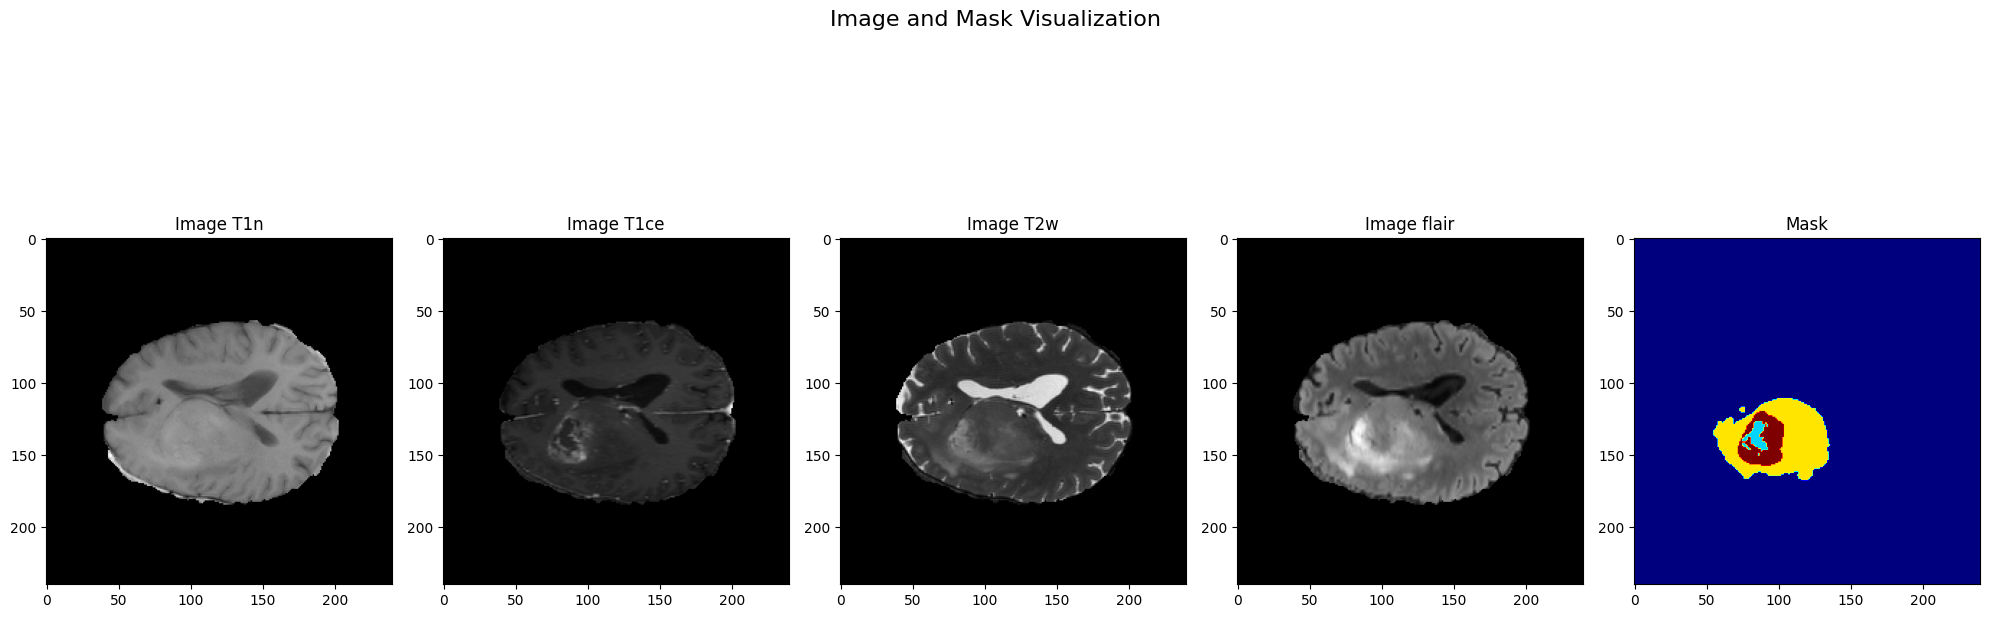

In [27]:
import random
import matplotlib.pyplot as plt

# Select random slice for visualization
# n_slice = random.randint(0, test_mask.shape[2]) 
# print(n_slice)

# Select static slice
n_slice = 90

# Select Colour Scheme
seg_colours = plt.cm.jet

# Create a grid of subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
fig.suptitle('Image and Mask Visualization', fontsize=16)

# T1 Image
axes[0].imshow(test_image_t1n[:,:,n_slice], cmap="gray")
axes[0].set_title('Image T1n') 

# T1 CE Image
axes[1].imshow(test_image_t1c[:,:,n_slice], cmap="gray")
axes[1].set_title('Image T1ce') 

# T2 Image
axes[2].imshow(test_image_t2w[:,:,n_slice], cmap="gray")
axes[2].set_title('Image T2w') 

# T2 Flair Image
axes[3].imshow(test_image_flair[:,:,n_slice], cmap="gray")
axes[3].set_title('Image flair') 

# Mask Image
axes[4].imshow(test_mask[:,:,n_slice], cmap = seg_colours)
axes[4].set_title('Mask')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
import time
from IPython.display import clear_output

n_slices = test_mask.shape[2]

while True:
    for n_slice in range(n_slices):
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        fig.suptitle('Image and Mask Visualization', fontsize=16)

        # Image T1n
        #img_t1n = test_img[:, :, n_slice, 0]
        axes[0].imshow(test_image_t1n[:,:,n_slice], cmap='gray')
        axes[0].set_title('Image T1n')

        # Image T1c
        #img_t1c = test_img[:, :, n_slice, 1]
        axes[1].imshow(test_image_t1c[:,:,n_slice], cmap='gray')
        axes[1].set_title('Image T1c')

        # Image T2w
        #img_t2w = test_img[:, :, n_slice, 2]
        axes[2].imshow(test_image_t2w[:,:,n_slice], cmap='gray')
        axes[2].set_title('Image T2w')

        # Image T2f
        #img_t2f = test_img[:, :, n_slice, 3]
        axes[3].imshow(test_image_flair[:,:,n_slice], cmap='gray')
        axes[3].set_title('Image T2f')

        # Mask
        #mask = test_mask[:, :, n_slice]
        axes[4].imshow(test_mask[:,:,n_slice], cmap=seg_colours)
        axes[4].set_title('Mask')

        plt.tight_layout()
        plt.show()

        # Delay in milliseconds
        time.sleep(0.0001)

        # Clear the previous plot
        clear_output(wait=True)

    # Break the loop if needed
    break

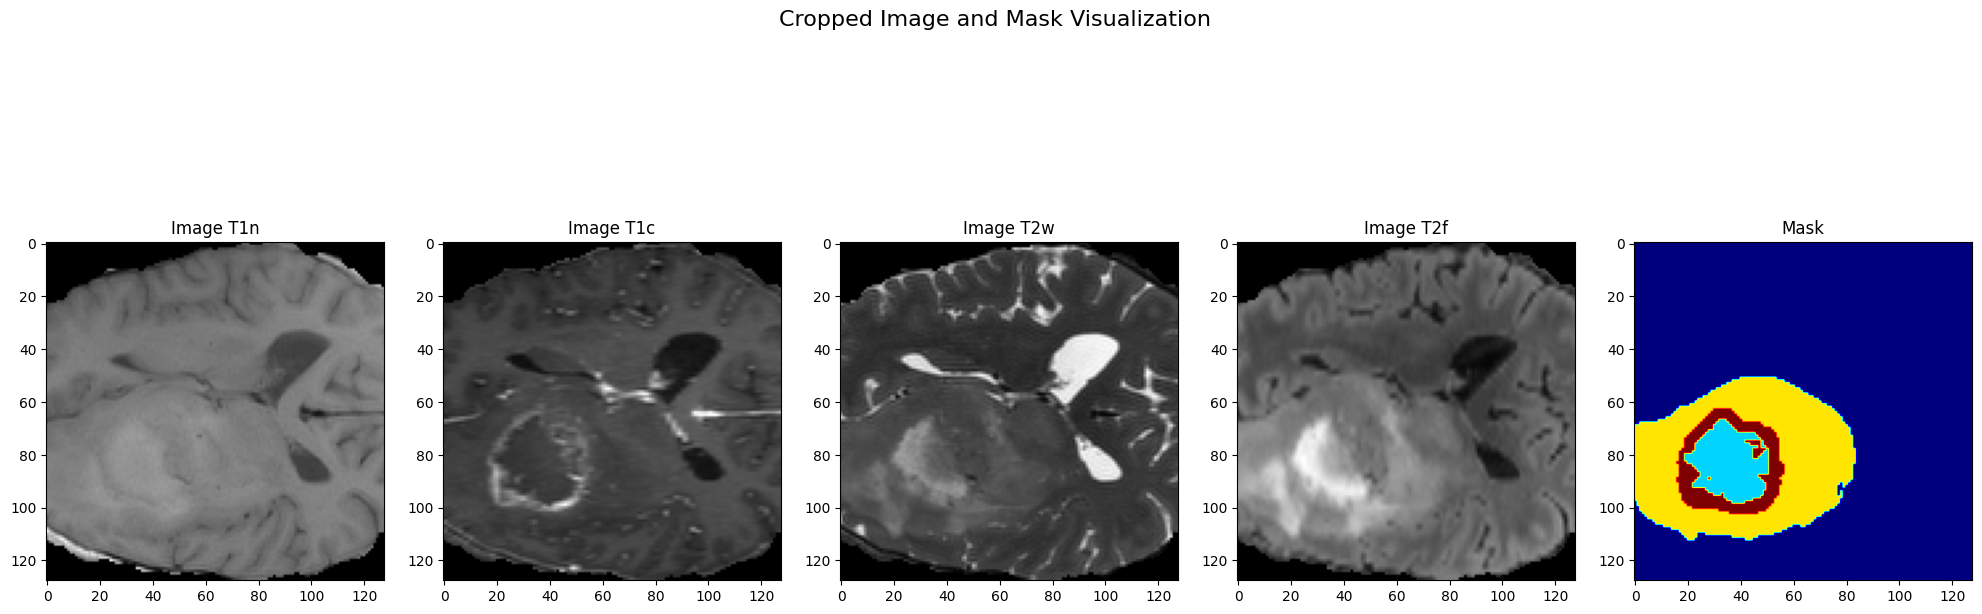

In [16]:
# Combine the 4 images into a single stack
combined_test_image = np.stack([test_image_t1n, test_image_t1c, test_image_t2w, test_image_flair],
                               axis=3)

# Cropping the image to 128x128x128
combined_test_image = combined_test_image[56:184, 56:184, 13:141]

# Cropping the mask precisely as above
test_mask_cropped = test_mask[56:184, 56:184, 13:141]

# Select static slice, adjusted according to cropping
n_slice = 71

# Create a grid of subplots with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(20, 8))
fig.suptitle('Cropped Image and Mask Visualization', fontsize=16)

# Image T1n
axes[0].imshow(combined_test_image[:,:,n_slice,0], cmap="gray")
axes[0].set_title('Image T1n')

# Image T1c
axes[1].imshow(combined_test_image[:,:,n_slice,1], cmap="gray")
axes[1].set_title('Image T1c')

# Image T2w
axes[2].imshow(combined_test_image[:,:,n_slice,2], cmap="gray")
axes[2].set_title('Image T2w')

# Image T2f
axes[3].imshow(combined_test_image[:,:,n_slice,3], cmap="gray")
axes[3].set_title('Image T2f')

# Mask
axes[4].imshow(test_mask_cropped[:,:,n_slice], cmap=seg_colours)
axes[4].set_title('Mask')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Visualising cropped images
n_slices = test_mask_cropped.shape[2]

while True:
    for n_slice in range(n_slices):
        #n_slice = 82
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        fig.suptitle('Cropped Image and Mask Visualization', fontsize=16)

        # Image T1n
        #img_t1n = test_img[:, :, n_slice, 0]
        axes[0].imshow(combined_test_image[:,:,n_slice,0], cmap="gray")
        axes[0].set_title('Image T1n')

        # Image T1c
        #img_t1c = test_img[:, :, n_slice, 1]
        axes[1].imshow(combined_test_image[:,:,n_slice,1], cmap="gray")
        axes[1].set_title('Image T1c')

        # Image T2w
        #img_t2w = test_img[:, :, n_slice, 2]
        axes[2].imshow(combined_test_image[:,:,n_slice,2], cmap="gray")
        axes[2].set_title('Image T2w')

        # Image T2f
        #img_t2f = test_img[:, :, n_slice, 3]
        axes[3].imshow(combined_test_image[:,:,n_slice,3], cmap="gray")
        axes[3].set_title('Image T2f')

        # Mask
        #mask = test_mask[:, :, n_slice]
        axes[4].imshow(test_mask_cropped[:,:,n_slice], cmap='jet')
        axes[4].set_title('Mask')

        plt.tight_layout()
        plt.show()

        # Delay for 200 milliseconds
        time.sleep(0.0001) #200

        # Clear the previous plot
        clear_output(wait=True)

    # Break the loop if needed
    break
